In [1]:
from dataclasses import dataclass
import os
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import List, Any, Dict

from matplotlib import pyplot as plt
import rasterio
from rasterio.warp import reproject, Resampling
from osgeo import gdal
import planetary_computer as pc
import pyproj
from pystac_client import Client
from shapely.geometry import box, mapping

In [2]:
STAC_API = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(STAC_API)

In [3]:
train_features = Path.cwd().parent / "training_data" / "train_features"
train_labels = Path.cwd().parent / "training_data" / "train_labels"

In [4]:
@dataclass
class ChipInfo:
    """
    Holds information about a training chip, including geospatial info for coregistration
    """

    path: str
    prefix: str
    crs: Any
    shape: List[int]
    transform: List[float]
    bounds: rasterio.coords.BoundingBox
    footprint: Dict[str, Any]


def get_footprint(bounds, crs):
    """Gets a GeoJSON footprint (in epsg:4326) from rasterio bounds and CRS"""
    transformer = pyproj.Transformer.from_crs(crs, "epsg:4326", always_xy=True)
    minx, miny = transformer.transform(bounds.left, bounds.bottom)
    maxx, maxy = transformer.transform(bounds.right, bounds.top)
    return mapping(box(minx, miny, maxx, maxy))


def get_chip_info(chip_path):
    """Gets chip info from a GeoTIFF file"""
    with rasterio.open(chip_path) as ds:
        chip_crs = ds.crs
        chip_shape = ds.shape
        chip_transform = ds.transform
        chip_bounds = ds.bounds

    # Use the first part of the chip filename as a prefix
    prefix = os.path.basename(chip_path).split("_")[0]

    return ChipInfo(
        path=chip_path,
        prefix=prefix,
        crs=chip_crs,
        shape=chip_shape,
        transform=chip_transform,
        bounds=chip_bounds,
        footprint=get_footprint(chip_bounds, chip_crs),
    )

In [5]:
def reproject_to_chip(
    chip_info, input_path, output_path, resampling=Resampling.nearest
):
    """
    Reproject a raster at input_path to chip_info, saving to output_path.

    Use Resampling.nearest for classification rasters. Otherwise use something
    like Resampling.bilinear for continuous data.
    """
    with rasterio.open(input_path) as src:
        kwargs = src.meta.copy()
        kwargs.update(
            {
                "crs": chip_info.crs,
                "transform": chip_info.transform,
                "width": chip_info.shape[1],
                "height": chip_info.shape[0],
                "driver": "GTiff",
            }
        )

        with rasterio.open(output_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=chip_info.transform,
                    dst_crs=chip_info.crs,
                    resampling=Resampling.nearest,
                )

In [6]:
def write_vrt(items, asset_key, dest_path):
    """Write a VRT with hrefs extracted from a list of items for a specific asset."""
    hrefs = [pc.sign(item.assets[asset_key].href) for item in items]
    vsi_hrefs = [f"/vsicurl/{href}" for href in hrefs]
    gdal.BuildVRT(dest_path, vsi_hrefs).FlushCache()

In [7]:
def create_chip_aux_file(
    chip_info, collection_id, asset_key, file_name, resampling=Resampling.nearest
):
    """
    Write an auxiliary chip file.

    The auxiliary chip file includes chip_info for the Collection and Asset, and is
    saved in the same directory as the original chip with the given file_name.
    """
    output_path = os.path.join(
        os.path.dirname(chip_info.path), f"{chip_info.prefix}_{file_name}"
    )
    search = catalog.search(collections=[collection_id], intersects=chip_info.footprint)
    items = list(search.get_items())
    with TemporaryDirectory() as tmp_dir:
        vrt_path = os.path.join(tmp_dir, "source.vrt")
        write_vrt(items, asset_key, vrt_path)
        reproject_to_chip(chip_info, vrt_path, output_path, resampling=resampling)
    return output_path

In [8]:
# Define a set of parameters to pass into create_chip_aux_file
aux_file_params = [
    ("nasadem", "elevation", "nasadem.tif", Resampling.bilinear),
    ("jrc-gsw", "extent", "jrc-gsw-extent.tif", Resampling.nearest),
    ("jrc-gsw", "occurrence", "jrc-gsw-occurrence.tif", Resampling.nearest),
    ("jrc-gsw", "recurrence", "jrc-gsw-recurrence.tif", Resampling.nearest),
    ("jrc-gsw", "seasonality", "jrc-gsw-seasonality.tif", Resampling.nearest),
    ("jrc-gsw", "transitions", "jrc-gsw-transitions.tif", Resampling.nearest),
    ("jrc-gsw", "change", "jrc-gsw-change.tif", Resampling.nearest),
]

In [9]:
chip_paths = []
for file_name in os.listdir(train_features):
    if file_name.endswith("_vv.tif"):
        chip_paths.append(train_features / file_name) #os.path.join('train_features', file_name))
print(f"{len(chip_paths)} chips found.")

542 chips found.


In [ ]:
# Iterate over the chips and generate all aux input files.
count = len(chip_paths)
for i, chip_path in enumerate(chip_paths):
    print(f"({i+1} of {count}) {chip_path}")
    if not (chip_path.parent / f"{chip_path.stem[0:5]}_nasadem.tif").exists():
        chip_info = get_chip_info(chip_path)
        for collection_id, asset_key, file_name, resampling_method in aux_file_params:
            print(f"  ... Creating chip data for {collection_id} {asset_key}")
            create_chip_aux_file(
                chip_info, collection_id, asset_key, file_name, resampling=resampling_method
            )

In [13]:
hxu12_vv = gdal.Open(str(train_features / "hbe54_vv.tif")).ReadAsArray()
hxu12_nasadem = gdal.Open(str(train_features / "hbe54_jrc-gsw-change.tif")).ReadAsArray()
hxu12_mask = gdal.Open(str(train_labels / "hbe54.tif")).ReadAsArray()

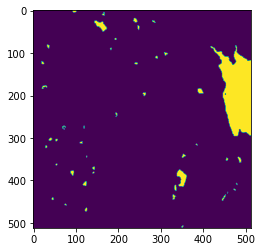

In [14]:
plt.imshow(hxu12_mask)

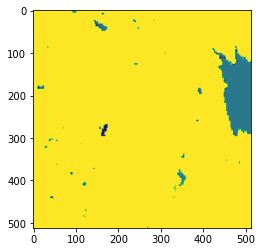

In [15]:
plt.imshow(hxu12_nasadem)

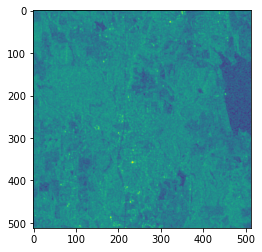

In [16]:
plt.imshow(hxu12_vv)